# Final Project Forecasting

Course: Predictive Modelling Analytics

Group Member:
- I Gusti Agung Jaya Hiswara (5026211122)
- Faqih
- Afaf
- Candeline


## Setup
### Initialize Global Variables

In [11]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 60 # 5 years
ARRIVAL = 'Kedatangan_Internasional'

### Import Libraries, Dependencides and Dataset

In [23]:
# Importing the libraries
%pip install pmdarima tensorflow

import pandas as pd
from pandas import read_csv
from pandas import to_datetime

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# import warnings
# warnings.filterwarnings('ignore')

# Importing the dataset
data = read_csv("Dataset/Data_FP_PAP-C.csv")
data.head()

Note: you may need to restart the kernel to use updated packages.


,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,01/01/2017
1,2017,2,8775,2,02/01/2017
2,2017,3,11305,3,03/01/2017
3,2017,4,13204,4,04/01/2017
4,2017,5,11792,5,05/01/2017


## Preprocessing
### Convert variables to the correct data type

In [24]:
data['Tanggal'] = to_datetime(data['Tanggal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tahun                     96 non-null     int64         
 1   Bulan                     96 non-null     int64         
 2   Kedatangan_Internasional  96 non-null     int64         
 3   Periode                   96 non-null     int64         
 4   Tanggal                   96 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.9 KB


In [ ]:
scaler = MinMaxScaler()
data[ARRIVAL] = scaler.fit_transform(data[ARRIVAL].values.reshape(-1, 1))
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000000001,0.671960,1,2017-01-01
1,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000000002,0.627682,2,2017-02-01
2,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000000003,0.808655,3,2017-03-01
3,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000000004,0.944492,4,2017-04-01
4,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000000005,0.843491,5,2017-05-01


## Exploratory Data Analysis (EDA)
### Visualization

In [ ]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Kedatangan Bandara Internasional Lombok {label}', fontsize=20)

    for v in var:
        plt.plot(data['Tanggal'], data[v], label=v)
    
    plt.xlim(data['Tanggal'].min(), data['Tanggal'].max())
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))

    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    ax.get_yaxis().get_major_formatter().set_scientific(False)

    plt.legend()  
    plt.show()

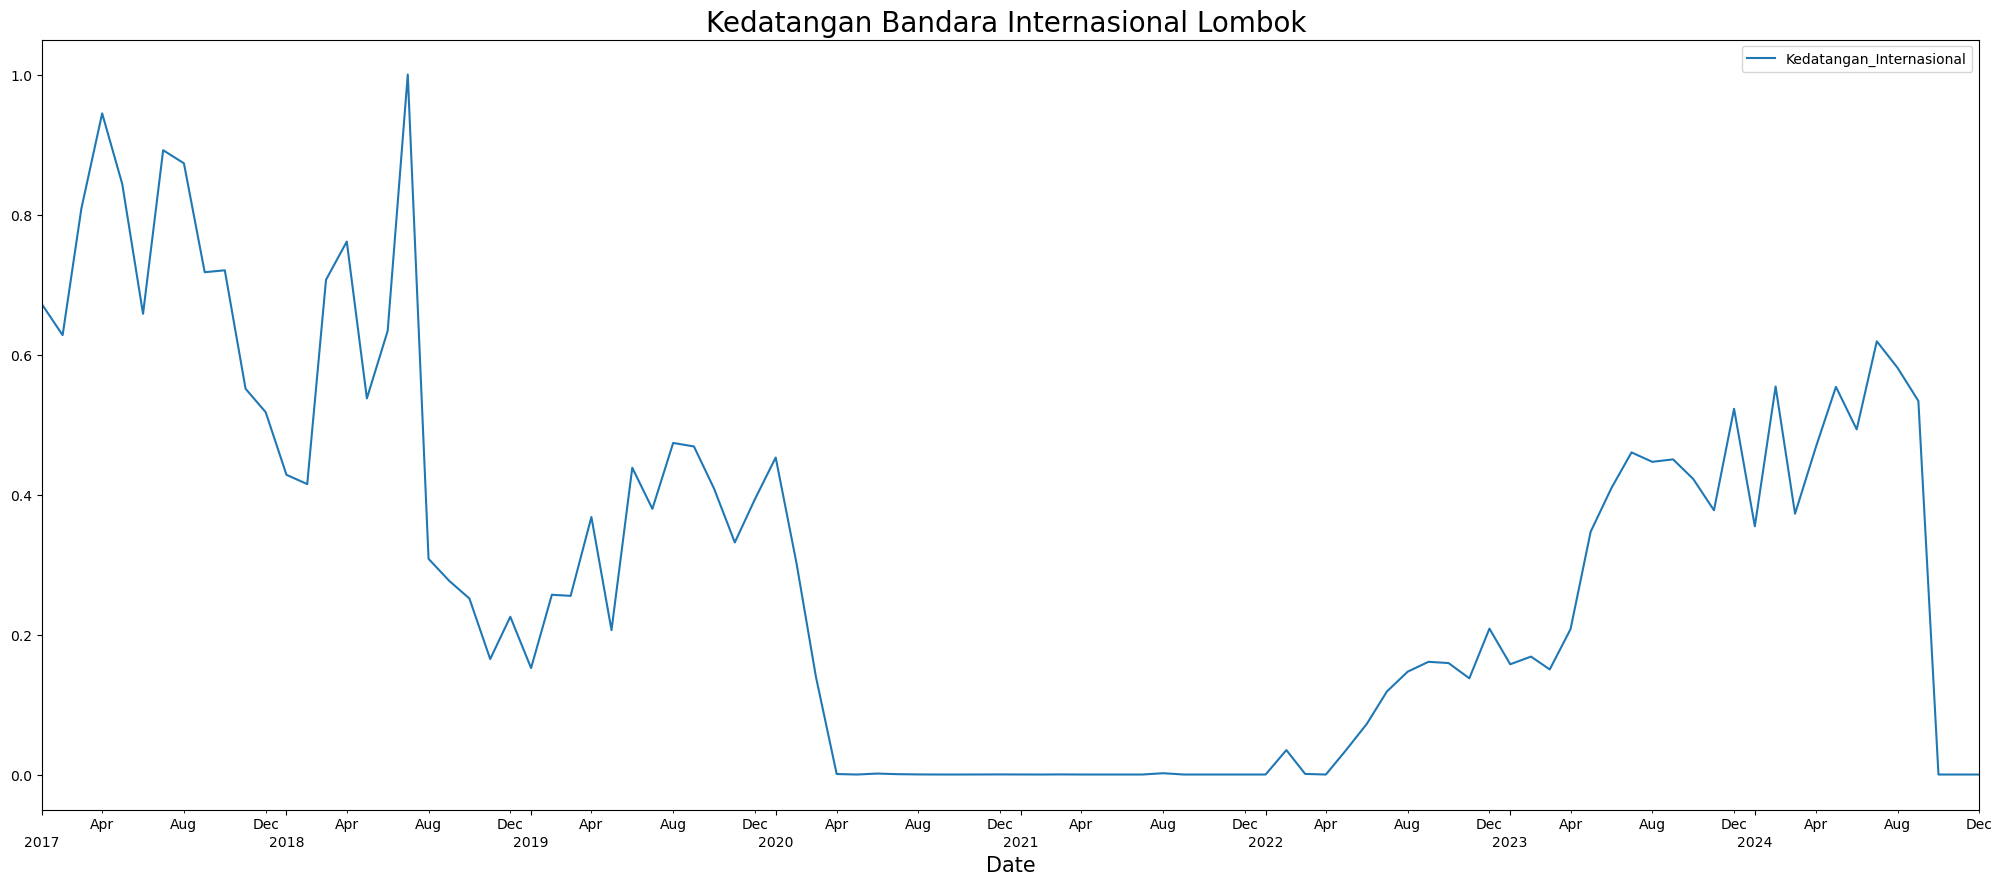

In [ ]:
visualize(data, [ARRIVAL])

## Modeling
### Data Windows

In [ ]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### Building Models
#### Exponential Smoothing (ETS)


In [ ]:
def create_ETS(train_data, seasonal_periods=None, seasonal='add', trend='add', damped_trend=False):
    model_ES = ExponentialSmoothing(train_data, seasonal_periods=seasonal_periods, 
                                    trend=trend, seasonal=seasonal, damped_trend=damped_trend)
    model_fitted = model_ES.fit()
    return model_fitted

def train_ETS(train_ratio=0.8, seasonal_periods=None, seasonal='add', trend='add', damped_trend=False):
    results = {}

    # Split data into training and testing sets
    train, test = train_test_split(data, train_size=train_ratio, shuffle=False)
    
    # Fit Exponential Smoothing model
    model_ES = create_ETS(train[ARRIVAL], seasonal_periods, seasonal, trend, damped_trend)
    
    # Generate predictions
    predictions_ES = model_ES.forecast(steps=len(test))
    predictions_ES = pd.Series(list(train[ARRIVAL]) + list(predictions_ES), index=data['Periode'])

    # Prepare the test series for evaluation
    pad = [None] * len(train[ARRIVAL])
    test_series = pd.Series(pad + list(test[ARRIVAL]), index=data['Periode'])

    # Save results
    results[ARRIVAL] = pd.DataFrame(data={'Predictions': predictions_ES, 'Actuals': test_series})

    return results

def forecast_exponential_smoothing(forecast_window, seasonal_periods=None, seasonal='add', trend='add', damped_trend=False):
    results = {}

    # Fit the model to the entire dataset
    model = create_ETS(data[ARRIVAL], seasonal_periods, seasonal, trend, damped_trend)
    
    # Generate forecasts
    pred = pd.Series(list(model.forecast(steps=forecast_window)), index=index_forecast)
    pred = round(pred, 2)
    results[ARRIVAL] = pred

    return results


#### ARIMA

In [ ]:
def create_ARIMA(train_data, I):
    model_ARIMA = auto_arima(train_data, start_p=0, start_q=0, d=I,
                             error_action='warn', trace=True, suppress_warnings=True,
                             stepwise=True, random_state=20, n_fits=50)
    return model_ARIMA

def train_ARIMA(train_ratio=0.8):
    results = {}

    train, test = train_test_split(data, train_size=train_ratio, shuffle=False)
    d_val = 0
    
    train_copy = train[ARRIVAL].copy()
    while adfuller(train_copy)[1] > .05:
        print('Performing differencing on data')
        train_copy = train_copy.diff().dropna()
        d_val += 1

    model_ARIMA = create_ARIMA(train[ARRIVAL], d_val)
    predictions_ARIMA = model_ARIMA.predict(n_periods=len(test))
    predictions_ARIMA = pd.Series(list(train[ARRIVAL]) + list(predictions_ARIMA), index=data['Periode'])
    
    pad = [None] * len(train[ARRIVAL])
    test_series = pd.Series(pad + list(test[ARRIVAL]), index=data['Periode'])
    
    results[ARRIVAL] = pd.DataFrame(data={'Predictions': predictions_ARIMA, 'Actuals': test_series})

    return results

def forecast_ARIMA(forecast_window):
    results = {}
    d_val = 0
    train_copy = data[ARRIVAL].copy()
    while adfuller(train_copy)[1] > .05:
        print('Performing differencing on data')
        train_copy = train_copy.diff().dropna()
        d_val += 1

    model = create_ARIMA(data[ARRIVAL], d_val)
    pred = pd.Series(list(model.predict(n_periods=forecast_window)), index=index_forecast)
    pred = round(pred, 2)
    results[ARRIVAL] = pred

    return results


#### HYBRID (ARIMA-LSTM)

In [ ]:
def create_ARIMA_LSTM(ARIMA, LSTM) -> pd.DataFrame:
    ARIMA_LSTM_df = pd.DataFrame({
        'Actuals': list(data[ARRIVAL].tail(len(LSTM))),
        'ARIMA_predictions': list(ARIMA.tail(len(LSTM))),
        'LSTM_predictions': list(LSTM)
    }, index=data['Periode'].tail(len(LSTM)))

    return ARIMA_LSTM_df

def train_ARIMA_LSTM(ARIMA_LSTM_dataframe) -> dict:
    prediction = []

    LSTM_MAE = mae(ARIMA_LSTM_dataframe['Actuals'], ARIMA_LSTM_dataframe['LSTM_predictions'])
    ARIMA_MAE = mae(ARIMA_LSTM_dataframe['Actuals'], ARIMA_LSTM_dataframe['ARIMA_predictions'])
    LSTM_weight = LSTM_MAE / (LSTM_MAE + ARIMA_MAE)
    ARIMA_weight = ARIMA_MAE / (LSTM_MAE + ARIMA_MAE)

    for row_idx in range(len(ARIMA_LSTM_dataframe)):
        predicted = ARIMA_LSTM_dataframe['ARIMA_predictions'][row_idx] * ARIMA_weight + ARIMA_LSTM_dataframe['LSTM_predictions'][row_idx] * LSTM_weight
        prediction.append(predicted)

    ARIMA_LSTM_dataframe['Predictions'] = prediction
    mae_result = mae(ARIMA_LSTM_dataframe['Predictions'], ARIMA_LSTM_dataframe['Actuals'])
    mape_result = mape(ARIMA_LSTM_dataframe['Predictions'], ARIMA_LSTM_dataframe['Actuals'])
    mse_result = mse(ARIMA_LSTM_dataframe['Predictions'], ARIMA_LSTM_dataframe['Actuals'])
    print(f"MAE = {mae_result}")
    print(f'MAPE = {mape_result}')
    print(f'MSE = {mse_result} \n')
    return ARIMA_LSTM_dataframe, LSTM_weight, ARIMA_weight
    
def forecast_ARIMA_LSTM(LSTM_weight: float, ARIMA_weight: float, ARIMA_forecast: pd.Series, LSTM_forecast: pd.Series) -> pd.Series:
    forecasted = []
    for i in range(FORECAST_WINDOW):
        forecasted.append(ARIMA_forecast[i] * ARIMA_weight + LSTM_forecast[i] * LSTM_weight)
    final_forecast = pd.Series(forecasted, index=index_forecast)
    return final_forecast


## Evaluation, Training and Testing

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test


### 1. 80% Train - 20% Test and Evaluation

#### Exponential Smoothing

In [ ]:
ETS_results = train_ETS(0.8)
compare_pred_actual(ETS_results)

#### ARIMA

Performing differencing on data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-92.561, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-94.843, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-97.076, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-94.384, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.937, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-96.166, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-98.598, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-96.969, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-97.452, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-96.552, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.166 seconds


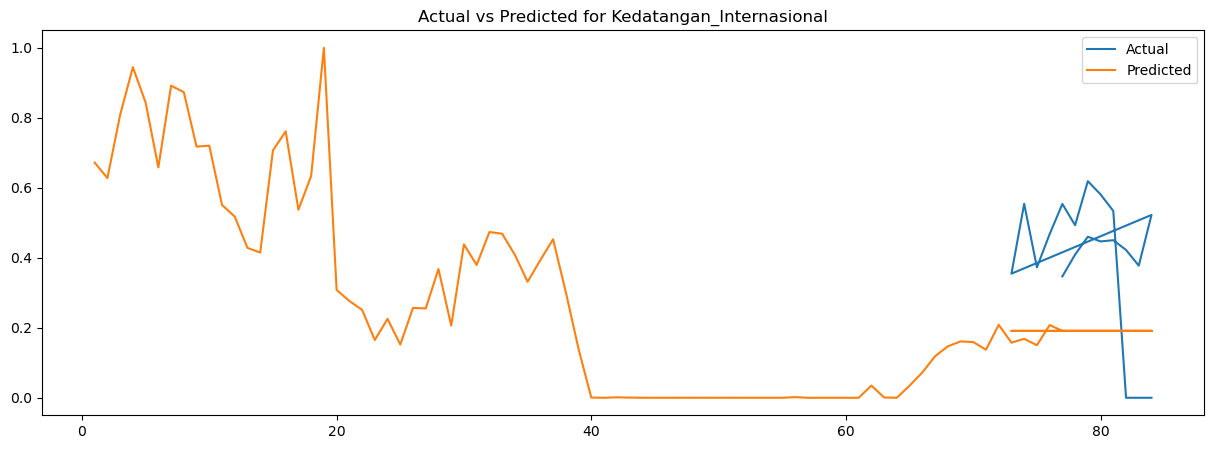

In [ ]:
ARIMA_results = train_ARIMA(0.8)
compare_pred_actual(ARIMA_results)

#### HYBRID (ARIMA-LSTM)

In [ ]:
result = {}
LSTM_weight = {}
ARIMA_weight = {}

# Process for a single variable 'ARRIVAL'
result['ARRIVAL'], LSTM_w, ARIMA_w = train_ARIMA_LSTM(create_ARIMA_LSTM(
    ARIMA_results['ARRIVAL']['Predictions'],
    LSTM_test_results['ARRIVAL']['Predictions'],
    'ARRIVAL'
))

LSTM_weight['ARRIVAL'] = LSTM_w
ARIMA_weight['ARRIVAL'] = ARIMA_w

# Compare predictions and actual values
compare_pred_actual(result)


KeyError: 'ARRIVAL'

### 2. 70% Train - 30% Test and Evaluation

### Exponential Smoothing (ETS)

### ARIMA

In [ ]:
ARIMA_results = train_ARIMA(0.7)
compare_pred_actual(ARIMA_results)

### HYBRID (ARIMA-LSTM)

### 3. 60% Train - 40% Test and Evaluation

#### Exponential Smoothing (ETS)

#### ARIMA

In [ ]:
ARIMA_results = train_ARIMA(0.6)
compare_pred_actual(ARIMA_results)

#### HYBRID (ARIMA-LSTM)

## Implementation


### Combine Histarical and Forecast Data

In [ ]:
def combine_data(region, forecast, data):
    historical = data[['Tanggal', region]].copy()
    historical.columns = ['Tanggal', 'Historical']
    forecast.columns = ['Tanggal', 'Forecast']
    combined = pd.merge(historical, forecast, on='Tanggal', how='outer')
    return combined

### Exponential Smoothing (ETS)

### ARIMA

Performing differencing on data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-109.438, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-112.038, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-112.983, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-111.170, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.144, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-111.214, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-112.854, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-114.483, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-112.600, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-112.664, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-113.631, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-114.315, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.211 seconds


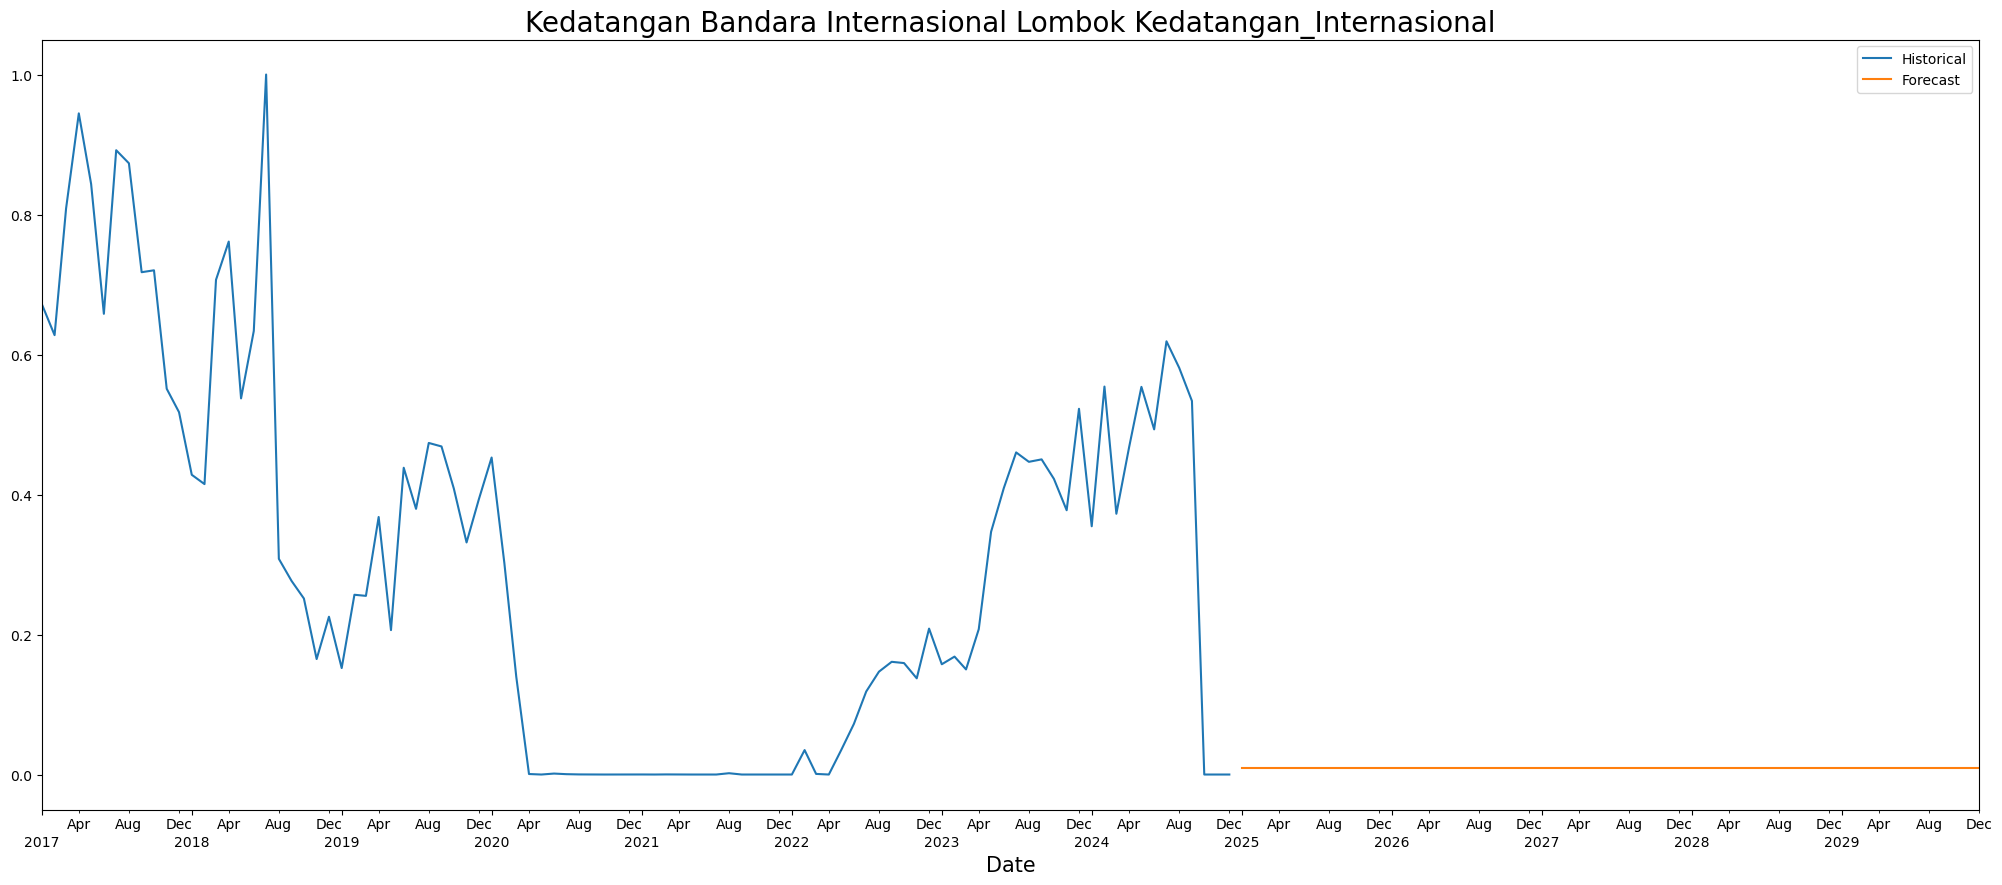

In [ ]:
ARIMA_forecast = forecast_ARIMA(FORECAST_WINDOW)
forecast = ARIMA_forecast[ARRIVAL]
forecast = forecast.reset_index()
forecast.columns = ['Tanggal', 'Forecast']
combined_data = combine_data(ARRIVAL, forecast, data)
visualize(combined_data, var=['Historical', 'Forecast'], label=ARRIVAL)


### Hybrid (ARIMA-LSTM)